In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Exercise 1: Decision Tree Classifier (30 points)

In this exercise we will train a decision tree classifier for neutrino experiment data from [the MiniBOONE experiment](https://www.fnal.gov/pub/science/experiments/intensity/miniboone.html).

The goal is to prepare a binary classification to distinguish electron neutrinos (signal) from muon neutrinos (background). The dataset is taken from the UCI ML dataset repository.

In [2]:
data = fetch_openml("miniboone", parser="auto", version=1)
X, y = data["data"].values, (data["target"].values == "True").astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

## part 1(a): Data Exploration and Visualization (10 points)

Explore the dataset before building your ML classifier:
- How many events are in the training data and testing data?
- How many input features are there for each point in the training data?
- Plot at least three of the input features for events with `y_train==0` and for events with `y_train==1`.

In [3]:
# Add code here to explore the dataset
print(f"Training features shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}, Testing labels shape: {y_test.shape}")


Training features shape: (104051, 50), Training labels shape: (104051,)
Testing features shape: (26013, 50), Testing labels shape: (26013,)


We can see that our training data consists of 104051 datapoints, which is 80% of the total data, where each datapoint is described by 50 features. The dataset for the training labels consists as well of 104051 datapoints since each input data needs an output. The output label here is one dimensional since this is a binary classification. Furthermore our testing data is 20% of the total data resulting in 26015 datapoints with each 50 features and similarily 26013 testing labels with one output. The whole dataset is given with 104051 + 26013  = 130064 datapoints.

In [4]:
# take a look at data values
print(y_train[1])
print(y_train[2])

print(len(X_train[0]))
print(X_train[0])
print(X_train[0][0])

1.0
0.0
50
[ 4.09724e+00  1.06346e+00  5.50024e+00  2.42023e-01  8.54701e-03
  4.46796e-01  1.45377e+00  8.56460e-01  3.38350e+00  1.94279e-01
  4.40352e+00  1.72699e+02  4.60198e-01  3.01134e-01  2.41283e+00
  1.03752e+03  5.51504e-01  6.75497e+00  2.94017e-01  1.38780e+00
 -4.18311e-02  2.75214e-01  1.05744e+02  4.54370e+00  4.58471e-01
 -1.98104e-01  1.73316e+02  1.27531e+00  2.00311e-01 -8.18247e-03
  5.36284e+00  1.32521e+00  5.89509e-01  3.77195e+02  1.16621e-01
  3.43302e-01  1.74317e+00 -3.72286e+00  1.25252e+00  8.97464e-02
  1.22217e+02 -8.80883e+00  6.00565e-01  3.98524e+00  0.00000e+00
  1.16346e-01 -1.22288e-03  1.16412e+00  2.64662e-01  2.10654e-01]
4.09724


I first plotted the data over the full range and noticed some outliers with values of -999. They clearly do not fit to the distribution of the data. It might be a good idea to remove them and build another decision tree, but actually I do not think they have a great impact given the amount of training data. I just don't really understand where they are coming from.

In [5]:
def plot_features_and_outliers(training_input_data, training_output_data, feature_int):
  # accessing data with correct labels and desired feature
  x_data_label_0 = []
  x_data_label_1 = []
  n_outlier_0 = 0
  n_outlier_1 = 0
  for i in range(len(training_output_data)):
    if training_output_data[i] == 0.0:
      if training_input_data[i][feature_int] < -800:
        n_outlier_0 += 1
        #print(f'Outlier of value {training_input_data[i][feature_int]} for data point nr. {i} and feature {feature_int} with label 0.')
      x_data_label_0.append(training_input_data[i][feature_int])
    elif training_output_data[i] == 1.0:
      if training_input_data[i][feature_int] < -800:
        n_outlier_1 += 1
        #print(f'Outlier of value {training_input_data[i][feature_int]} for data point nr. {i} and feature {feature_int} with label 0.')
      x_data_label_1.append(training_input_data[i][feature_int])

  print(f'We have {n_outlier_0} outliers with label 0 and {n_outlier_1} outliers with label 1.')

  # Plot
  plt.figure(figsize=(6, 4))
  plt.hist(x_data_label_0, bins=50, color='pink', label='Data with label 0')
  plt.hist(x_data_label_1, bins = 50, color='purple', label='Data with label 1')
  plt.xlabel('Value of Feature')
  plt.ylabel('Number of Events')
  plt.legend()
  plt.title(f"Feature Nr. {feature_int}")
  plt.show()



We have 367 outliers with label 0 and 9 outliers with label 1.


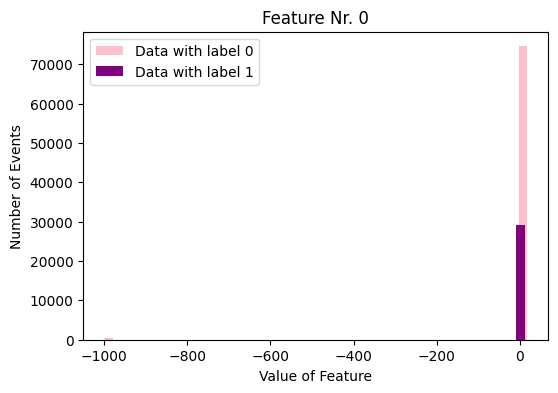

We have 367 outliers with label 0 and 9 outliers with label 1.


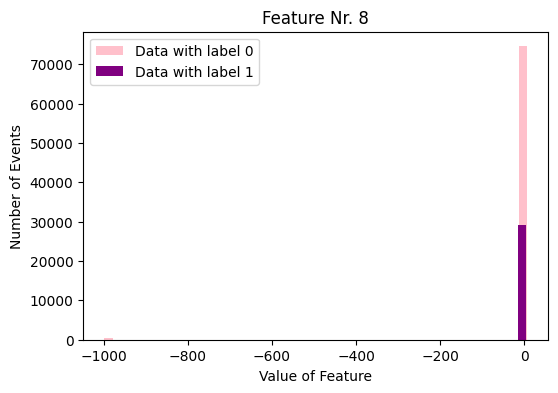

We have 367 outliers with label 0 and 9 outliers with label 1.


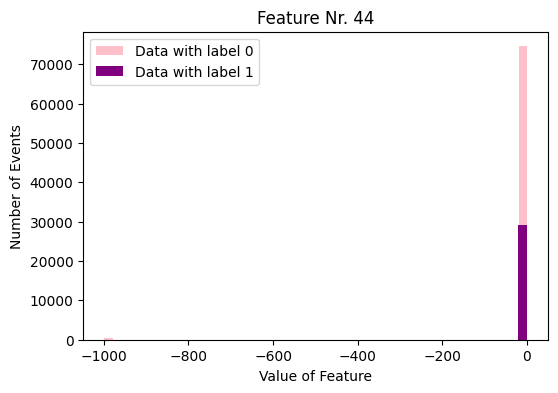

In [6]:
plot_features_and_outliers(X_train, y_train, 0)
plot_features_and_outliers(X_train, y_train, 8)
plot_features_and_outliers(X_train, y_train, 44)

In [7]:
def plot_features(training_input_data, training_output_data, feature_int, x_min, x_max, logscale=False):
  # accessing data with correct labels and desired feature
  x_data_label_0 = []
  x_data_label_1 = []
  for i in range(len(training_output_data)):
    if training_output_data[i] == 0.0:
      x_data_label_0.append(training_input_data[i][feature_int])
    elif training_output_data[i] == 1.0:
      x_data_label_1.append(training_input_data[i][feature_int])

  # Plot
  plt.figure(figsize=(6, 4))
  plt.hist(x_data_label_0, bins=50,range=(x_min, x_max), color='pink', label='Data with label 0')
  plt.hist(x_data_label_1, bins = 50,range=(x_min, x_max), color='purple', label='Data with label 1')
  plt.xlabel('Value of Feature')
  plt.xlim([x_min, x_max]) # ignore the outliers
  plt.ylabel('Number of Events')
  if logscale:
      plt.yscale('log')
  plt.legend()
  plt.title(f"Feature Nr. {feature_int}")
  plt.show()



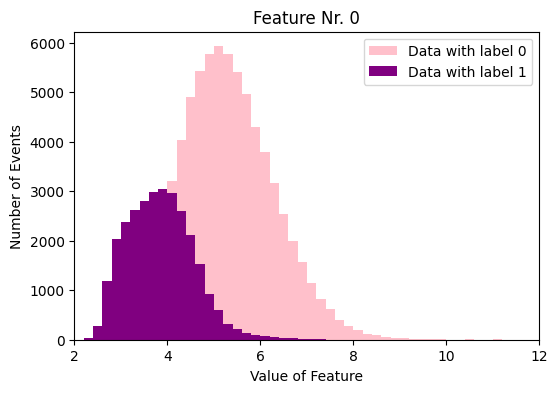

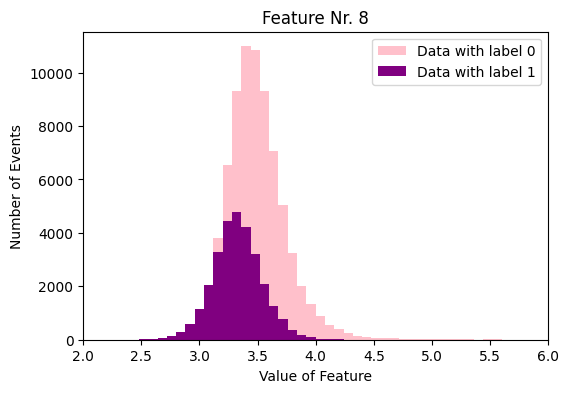

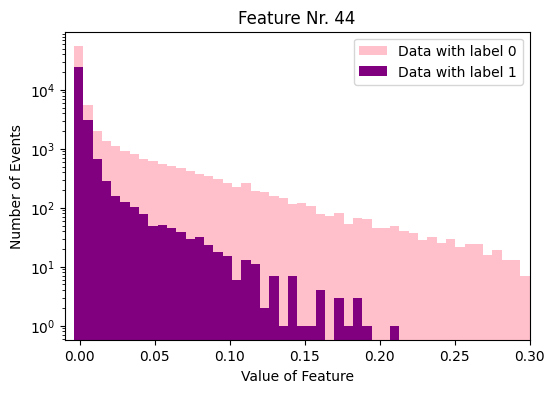

In [8]:
plot_features(X_train, y_train, 0, 2, 12)
plot_features(X_train, y_train, 8, 2, 6)
plot_features(X_train, y_train, 44, -0.01, 0.3, True)

## part 1(b): Decision Tree (10 points)

Train a simple `DecisionTreeClassifier` with `max_depth=5` and the `gini` criterion to separate the electron neutrino signal and muon neutrino background.

Calculate the performance of the Decision Tree:
- confusion matrix
- ROC curve
- Area Under Curve (AUC)


In [9]:
score=[]
dtclassifier = DecisionTreeClassifier(criterion='gini', max_depth=5)
dtclassifier.fit(X_train, y_train)
dtclassifier.score(X_train,y_train),dtclassifier.score(X_test,y_test)

(0.8940231232760858, 0.8912466843501327)

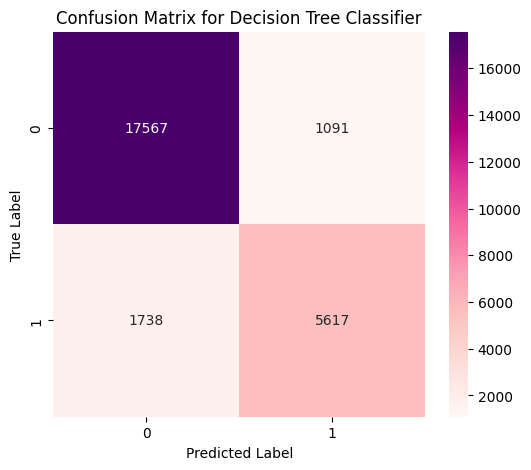

In [10]:
# Get predictions from the DecisionTreeClassifier on the test set
y_pred_dt = dtclassifier.predict(X_test)

# Create confusion matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='RdPu')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

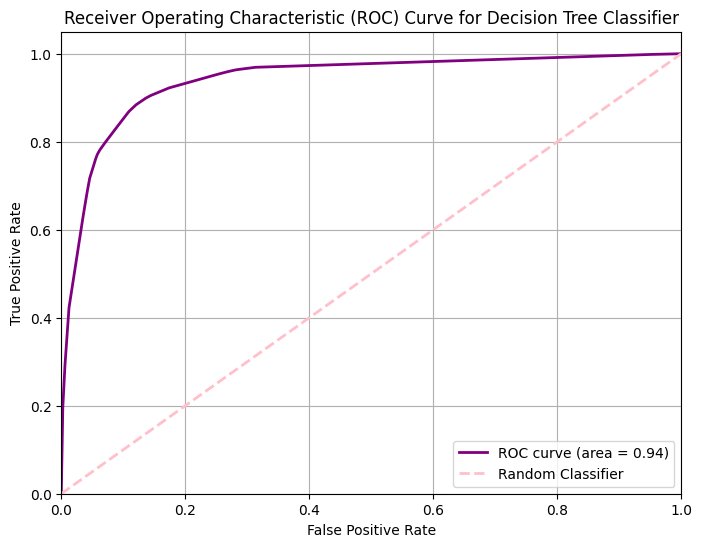

In [11]:
# Get predicted probabilities for the positive class
y_pred_proba_dtclf = dtclassifier.predict_proba(X_train)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba_dtclf)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='pink', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## part 1(c): Gini impurity measure

Visualize the decision tree, and pick three of the leaf nodes in your decision tree visualization.

For each node, calculate the Gini impurity by hand to check against the calculation from scikit-learn. Show the steps of your calculation and the result.

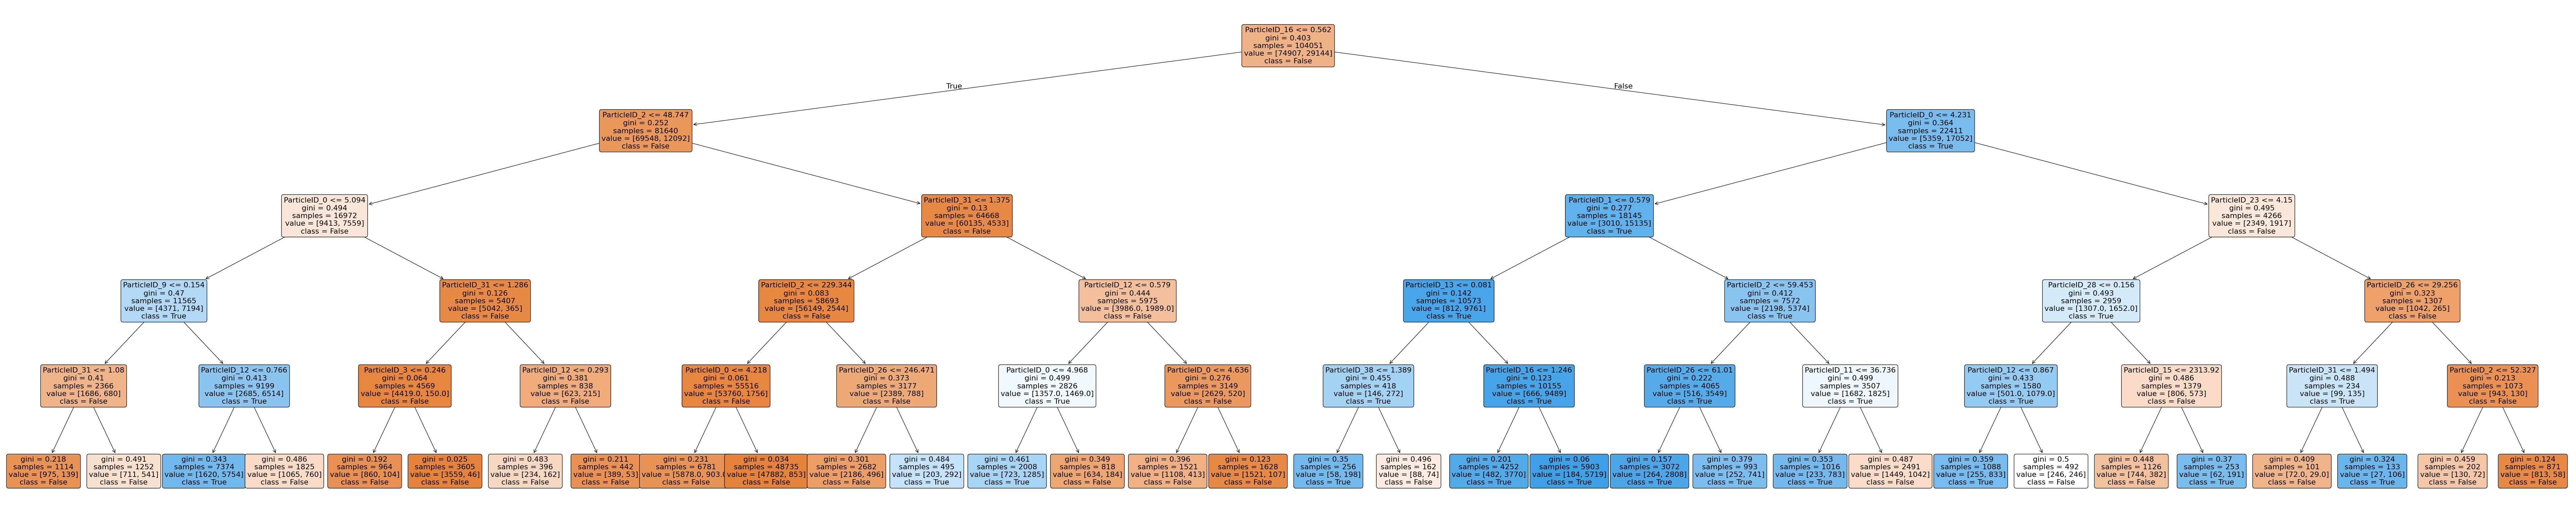

In [12]:
plt.figure(figsize=(100, 20))
plot_tree(
    dtclassifier,
    feature_names=data['feature_names'],
    class_names=["False", "True"],
    filled=True,
    rounded=True,
    fontsize=16
)
plt.show()



**Gini impurity for leaf node with ParticleID_16<=0.562**

$N_{total} = 104051$, $N_{false}= 74907$, $N_{true}= 29144$

$gini = 1 - ((\frac{74907}{104051})^2 + (\frac{29144}{104051})^2) = 0.4032821883883695$ -> same as in plot


**Gini impurity for leaf node with ParticleID_2<=48.747**

$N_{total} = 81640$, $N_{false}= 69548$, $N_{true}= 12092$

$gini = 1 - ((\frac{69548}{81640})^2 + (\frac{12092}{81640})^2) = 0.25235202119413347$ -> same as in plot

**Gini impurity for leaf node with ParticleID_0<=5.094**

$N_{total} = 16972$, $N_{false}= 9413$, $N_{true}= 7559$

$gini = 1 - ((\frac{9413}{16972})^2 + (\frac{7559}{16972})^2) = 0.494033448167585$ -> same as in plot

# Exercise 2: Backpropagation (30 points)

In this exercise you will gain some experience with the backpropagation equations and the numerical calculations of the gradient.



## part 2(a): Backpropagation theory (15 points)

Complete the proofs of [Nielsen's equations BP3 and BP4](http://neuralnetworksanddeeplearning.com/chap2.html#proof_of_the_four_fundamental_equations_(optional)).

In Nielsen's notation (but with layer numbers written in parenthesis for clarity):
$$
\begin{align}
\frac{\partial C}{\partial b_j^{(l)}} &= \delta_j^{(l)} & \quad \quad \text{(BP3)} \\
\frac{\partial C}{\partial w_{jk}^{(l)}} &= a_k^{(l-1)} \delta_j^{(l)} & \quad \quad \text{(BP4)}
\end{align}
$$
where $C$ is the cost function (loss function), $w$ and $b$ are weights and biases, $a$ is the post-activation output for the layer, and $\delta$ is the error of a single neuron.

**Proof of BP3**

$\frac{\partial C}{\partial b_j^l} = \sum_i \frac{\partial C}{\partial z_i^l}\frac{\partial z_i^l}{\partial b_j^l}$ with $z_i^l = \sum_m w_{im}^l a_m^{l-1} + b_i^l$ we get for $\frac{\partial z_i^l}{\partial b_j^l}=\delta_{ij}$ which is the Kronecker-Delta in this case. Additionally we can apply that per definition the error is given with $\delta_i^l=\frac{\partial C}{\partial z_i^l}$.

All together we get $\frac{\partial C}{\partial b_j^l}=\sum_i \frac{\partial C}{\partial z_i^l}\frac{\partial z_i^l}{\partial b_j^l}= \sum_i \frac{\partial C}{\partial z_i^l}\delta_{ij}=\delta_j^l$.

**Proof of BP4**

$\frac{\partial C}{\partial w_{jk}^l} = \sum_i \frac{\partial C}{\partial z_i^l}\frac{\partial z_i^l}{\partial w_{jk}^l}$ with $z_i^l = \sum_m w_{im}^l a_m^{l-1} + b_i^l$ we get for $\frac{\partial z_i^l}{\partial w_{jk}^l}=a_k^{l-1}\delta_{ij}$ which is again the Kronecker-Delta in this case. Additionally we can apply that per definition the error is given with $\delta_i^l=\frac{\partial C}{\partial z_i^l}$.

All together we get $\frac{\partial C}{\partial w_{jk}^l} = \sum_i \frac{\partial C}{\partial z_i^l}\frac{\partial z_i^l}{\partial w_{jk}^l}= \sum_i \frac{\partial C}{\partial z_i^l}a_k^{l-1}\delta_{ij}=\delta_j^la_k^{l-1}$.

## part 2(b): Numerical calculation (15 points)

Consider a single perceptron node with 1-dimensional input $x$. The weight and bias of the node are $w=0.5$ and $b=0.1$. We use the ReLU activation function on the output of the node and the mean square error loss function.

If the data input and target are $x=1, y=1$:
- What is the loss function value?
- What is the gradient $\partial L/\partial w$?
- What is the gradient $\partial L/\partial b$?

You can do this by hand. Show your work, and feel free to check your answer with some code.




**Calculation by hand**

We have given $w=0.5$, $b=0.1$, $x=1$, $w=0.5$ and $y_{in}=1$.

First, we calculate $z=wx+b=0.6$, then we apply the activation function $\sigma(z)=max(0,z)=0.6=y_{pred}$. With that we can determine the loss $L=(y_{in}-y_{pred})^2=0.16$.

To determine the gradients we can directly insert z in the loss function due to the properties of the ReLU activation function for $z>0$. We get $L=(y_{in}-(wx+b))^2$ and derive the gradients accordingly. For the first gradient we receive $\frac{\partial L}{\partial w} = 2 (y_{in}-(wx+b))(-x)=-0.8$ and for the second we get $\frac{\partial L}{\partial b} = 2 (y_{in}-(wx+b))(-1)=-0.8.$

In [13]:
def z(w,x,b):
  return w*x+b

def sigma(z):
  return max(0,z)

def loss(y_in, y_pred):
  return (y_in - y_pred)**2

def gradient_1(y_in, w, x, b):
  return 2*(y_in - w*x -b)*(-x)

def gradient_2(y_in, w, x, b):
  return 2*(y_in - w*x -b)*(-1)


In [14]:
z_1 = z(0.5,1,0.1)
y_pred = sigma(z_1)
L = loss(1, y_pred)
grad_1 = gradient_1(1,0.5,1,0.1)
grad_2 = gradient_2(1,0.5,1,0.1)

print(f'z = {z_1}, y_pred = {y_pred}, L = {L}, dL/dw = {grad_1}, dL/db = {grad_2}')

z = 0.6, y_pred = 0.6, L = 0.16000000000000003, dL/dw = -0.8, dL/db = -0.8


# Exercise 3: Deep Neural Networks (40 points)

In this exercise we will train a deep neural network for neutrino experiment data from [the MiniBOONE experiment](https://www.fnal.gov/pub/science/experiments/intensity/miniboone.html).

The goal is similar to Exercise 1 above: prepare a binary classification to distinguish electron neutrinos (signal) from muon neutrinos (background).

In this exercise, you will set up a neural network model using PyTorch and train it using the MiniBOONE training data, then test it on the testing data.

## part 3(a) (20 points): DNN with tanh activation

Implement a deep neural network (at least 1 hidden layer between the input and output layers) to classify events as electron neutrinos (signal) or muon neutrinos (background). Use the tanh activation function, except in the output layer.

Here are some starting points for the DNN:
- 3 hidden layers w/ 64 units each
- BCE loss function
- SGD optimizer w/ batch size of 128

You should expect to train for at least 50 epochs.

In [15]:
# convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1) # does not work otherwise because of shape
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor  = torch.FloatTensor(y_test).unsqueeze(1)

# create TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# create PyTorch DataLoader with batches for training
train_loader = DataLoader(
    train_dataset,
    batch_size=128,      # Adjust based on your needs, 1 is stochastic gd
    shuffle=True        # Shuffle training data in batches
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False       # Don't shuffle test data
)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batches per epoch: {len(train_loader)}")

Training samples: 104051
Test samples: 26013
Batches per epoch: 813


Total data with 104051 elements is separated into 813 bachtes with 128 elements.

In [16]:
# define DNN model
model = nn.Sequential(
    nn.Linear(50, 64),
    nn.Tanh(),
    nn.Linear(64, 80),
    nn.Tanh(),
    nn.Linear(80, 64),
    nn.Tanh(),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# training loop
num_epochs = 100
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [1/100], Loss: 0.6627
Epoch [2/100], Loss: 0.4421
Epoch [3/100], Loss: 0.4243
Epoch [4/100], Loss: 0.4431
Epoch [5/100], Loss: 0.3814
Epoch [6/100], Loss: 0.3630
Epoch [7/100], Loss: 0.3974
Epoch [8/100], Loss: 0.3062
Epoch [9/100], Loss: 0.2164
Epoch [10/100], Loss: 0.2701
Epoch [11/100], Loss: 0.2847
Epoch [12/100], Loss: 0.3257
Epoch [13/100], Loss: 0.2724
Epoch [14/100], Loss: 0.2736
Epoch [15/100], Loss: 0.3114
Epoch [16/100], Loss: 0.2860
Epoch [17/100], Loss: 0.1824
Epoch [18/100], Loss: 0.2888
Epoch [19/100], Loss: 0.3036
Epoch [20/100], Loss: 0.2949
Epoch [21/100], Loss: 0.2903
Epoch [22/100], Loss: 0.2723
Epoch [23/100], Loss: 0.2552
Epoch [24/100], Loss: 0.3694
Epoch [25/100], Loss: 0.3213
Epoch [26/100], Loss: 0.2804
Epoch [27/100], Loss: 0.2103
Epoch [28/100], Loss: 0.2626
Epoch [29/100], Loss: 0.3350
Epoch [30/100], Loss: 0.2210
Epoch [31/100], Loss: 0.2585
Epoch [32/100], Loss: 0.3638
Epoch [33/100], Loss: 0.3289
Epoch [34/100], Loss: 0.3242
Epoch [35/100], Loss: 0

## part 3(b) (10 points): DNN performance assessment

Calculate the performance of the DNN on the testing data:
- confusion matrix
- ROC curve
- Area Under Curve (AUC)



tensor(3.4483)


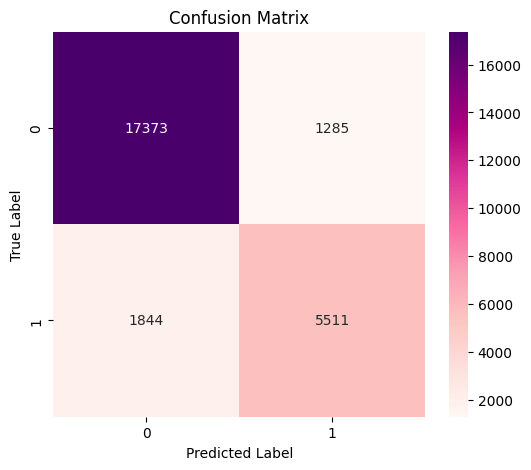

In [17]:
# Get all predictions
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        outputs = model(batch_features)
        predictions = (outputs > 0.5).float()
        loss = criterion(predictions, batch_labels)
        all_predictions.extend(predictions.numpy())
        all_labels.extend(batch_labels.numpy())

print(loss)

# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Accuracy on training data: 0.8797
Thresholds (first 10): [       inf 0.9930229  0.99184835 0.9898538  0.9898469  0.9888192
 0.98881906 0.9877291  0.9876615  0.9854484 ]


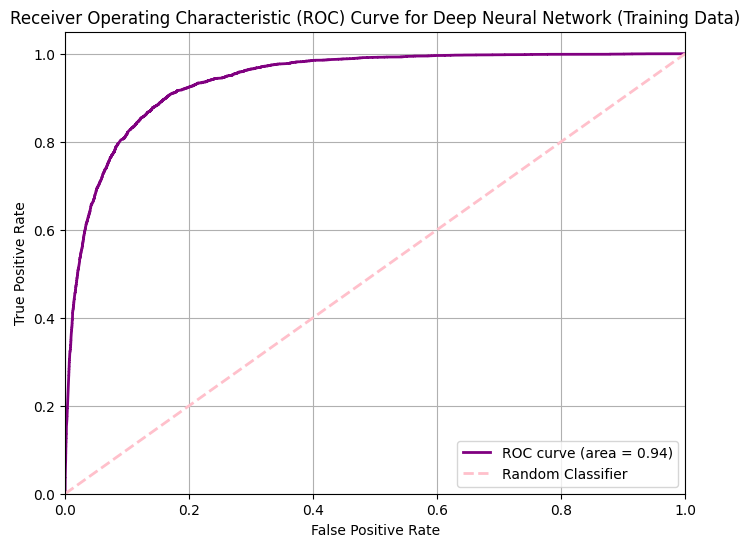

In [18]:
# Ensure the model is on the correct device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()

all_labels = []
all_predictions = []

# Disable gradient calculations for inference
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        all_predictions.extend(output.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(all_labels)
y_pred_proba = np.array(all_predictions)

# For binary classification with Sigmoid, output is already probability, but ensure shape is correct
# y_pred_proba will be (N, 1), we need (N,) for roc_curve
y_pred_proba = y_pred_proba.flatten()
y_true = y_true.flatten()

# Convert probabilities to binary predictions for accuracy calculation (e.g., threshold at 0.5)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Calculate Accuracy
accuracy = accuracy_score(y_true, y_pred_binary)
print(f"Accuracy on training data: {accuracy:.4f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print("Thresholds (first 10):", thresholds[:10]) # Print first 10 thresholds, not all

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='pink', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Deep Neural Network (Training Data)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## part 3(c) (10 points): Change of activation function

Replace the sigmoid activation functions with the ReLU activation functions, in the layers where it is possible.
(Hint: there is one layer where you can't use the ReLU activation function--why not?)

What happens with the training and performance? Can you improve the performance relative to the original training with sigmoid activation functions?

In [19]:
def plot_confusion_matrix(model_name):
  # Get all predictions
  model_name.eval()
  all_predictions = []
  all_labels = []

  with torch.no_grad():
      for batch_features, batch_labels in test_loader:
          outputs = model(batch_features)
          predictions = (outputs > 0.5).float()
          loss = criterion(predictions, batch_labels)
          all_predictions.extend(predictions.numpy())
          all_labels.extend(batch_labels.numpy())

  print(loss)

  # Create confusion matrix
  cm = confusion_matrix(all_labels, all_predictions)

  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu')
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()

In [20]:
def plot_ROC_curve(model_name):
  # Ensure the model is on the correct device (CPU or GPU)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model_name.to(device)

  # Set the model to evaluation mode
  model_name.eval()

  all_labels = []
  all_predictions = []

  # Disable gradient calculations for inference
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          all_predictions.extend(output.cpu().numpy())
          all_labels.extend(target.cpu().numpy())

  # Convert lists to numpy arrays
  y_true = np.array(all_labels)
  y_pred_proba = np.array(all_predictions)

  # For binary classification with Sigmoid, output is already probability, but ensure shape is correct
  # y_pred_proba will be (N, 1), we need (N,) for roc_curve
  y_pred_proba = y_pred_proba.flatten()
  y_true = y_true.flatten()

  # Convert probabilities to binary predictions for accuracy calculation (e.g., threshold at 0.5)
  y_pred_binary = (y_pred_proba > 0.5).astype(int)

  # Calculate Accuracy
  accuracy = accuracy_score(y_true, y_pred_binary)
  print(f"Accuracy on training data: {accuracy:.4f}")

  # Calculate ROC curve
  fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
  roc_auc = auc(fpr, tpr)

  print("Thresholds (first 10):", thresholds[:10]) # Print first 10 thresholds, not all

  # Plot ROC curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='purple', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='pink', lw=2, linestyle='--', label='Random Classifier')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve for Deep Neural Network (Training Data)')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()

In [21]:
# define DNN model
model_ReLU = nn.Sequential(
    nn.Linear(50, 64),
    nn.ReLU(),
    nn.Linear(64, 80),
    nn.ReLU(),
    nn.Linear(80, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 0.5926
Epoch [2/50], Loss: 0.5360
Epoch [3/50], Loss: 0.5831
Epoch [4/50], Loss: 0.4957
Epoch [5/50], Loss: 0.5729
Epoch [6/50], Loss: 0.5664
Epoch [7/50], Loss: 0.5762
Epoch [8/50], Loss: 0.5035
Epoch [9/50], Loss: 0.5217
Epoch [10/50], Loss: 0.5808
Epoch [11/50], Loss: 0.5809
Epoch [12/50], Loss: 0.4685
Epoch [13/50], Loss: 0.4656
Epoch [14/50], Loss: 0.4090
Epoch [15/50], Loss: 0.3863
Epoch [16/50], Loss: 0.4654
Epoch [17/50], Loss: 0.5069
Epoch [18/50], Loss: 0.5237
Epoch [19/50], Loss: 0.4832
Epoch [20/50], Loss: 0.5285
Epoch [21/50], Loss: 0.5690
Epoch [22/50], Loss: 0.4832
Epoch [23/50], Loss: 0.3336
Epoch [24/50], Loss: 0.4708
Epoch [25/50], Loss: 0.4707
Epoch [26/50], Loss: 0.4196
Epoch [27/50], Loss: 0.4814
Epoch [28/50], Loss: 0.5003
Epoch [29/50], Loss: 0.6080
Epoch [30/50], Loss: 0.5512
Epoch [31/50], Loss: 0.4617
Epoch [32/50], Loss: 0.4000
Epoch [33/50], Loss: 0.4649
Epoch [34/50], Loss: 0.4022
Epoch [35/50], Loss: 0.5524
Epoch [36/50], Loss: 0.4067
E

tensor(24.1379)


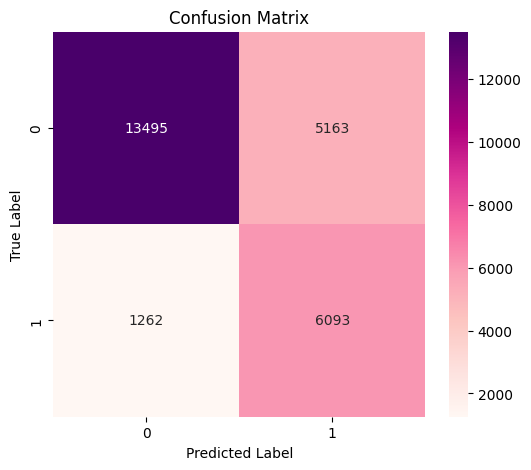

Accuracy on training data: 0.7530
Thresholds (first 10): [       inf 0.52203274 0.5220327  0.5220326  0.5220325  0.52197355
 0.52196544 0.5215864  0.52150035 0.43866765]


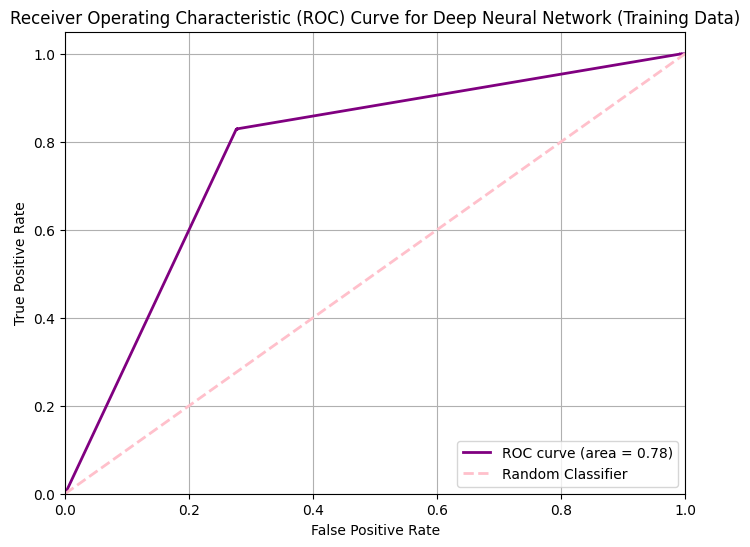

In [22]:
plot_confusion_matrix(model_ReLU)
plot_ROC_curve(model_ReLU)

Replacing tanh(z) with ReLU is definitely a  downgrade. We have a lot false positives.

In [23]:
# define DNN model
model_Sigmoid = nn.Sequential(
    nn.Linear(50, 64),
    nn.Sigmoid(),
    nn.Linear(64, 80),
    nn.Sigmoid(),
    nn.Linear(80, 64),
    nn.Sigmoid(),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 0.4993
Epoch [2/50], Loss: 0.4316
Epoch [3/50], Loss: 0.4385
Epoch [4/50], Loss: 0.5101
Epoch [5/50], Loss: 0.4535
Epoch [6/50], Loss: 0.5290
Epoch [7/50], Loss: 0.4270
Epoch [8/50], Loss: 0.4734
Epoch [9/50], Loss: 0.4932
Epoch [10/50], Loss: 0.5113
Epoch [11/50], Loss: 0.4236
Epoch [12/50], Loss: 0.4291
Epoch [13/50], Loss: 0.4591
Epoch [14/50], Loss: 0.4074
Epoch [15/50], Loss: 0.4567
Epoch [16/50], Loss: 0.3167
Epoch [17/50], Loss: 0.5072
Epoch [18/50], Loss: 0.5077
Epoch [19/50], Loss: 0.4342
Epoch [20/50], Loss: 0.4745
Epoch [21/50], Loss: 0.4488
Epoch [22/50], Loss: 0.4236
Epoch [23/50], Loss: 0.3680
Epoch [24/50], Loss: 0.5046
Epoch [25/50], Loss: 0.4931
Epoch [26/50], Loss: 0.3801
Epoch [27/50], Loss: 0.4950
Epoch [28/50], Loss: 0.4733
Epoch [29/50], Loss: 0.3921
Epoch [30/50], Loss: 0.5010
Epoch [31/50], Loss: 0.5093
Epoch [32/50], Loss: 0.4535
Epoch [33/50], Loss: 0.5395
Epoch [34/50], Loss: 0.5216
Epoch [35/50], Loss: 0.3896
Epoch [36/50], Loss: 0.4429
E

tensor(27.5862)


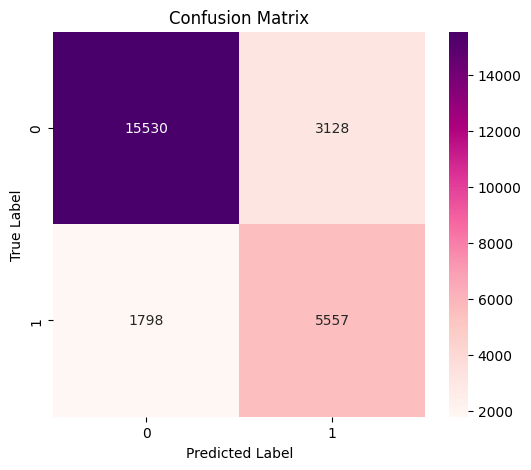

Accuracy on training data: 0.8106
Thresholds (first 10): [       inf 0.6470213  0.647021   0.64702    0.64701235 0.64696
 0.09401069 0.09370708 0.09353212 0.09352265]


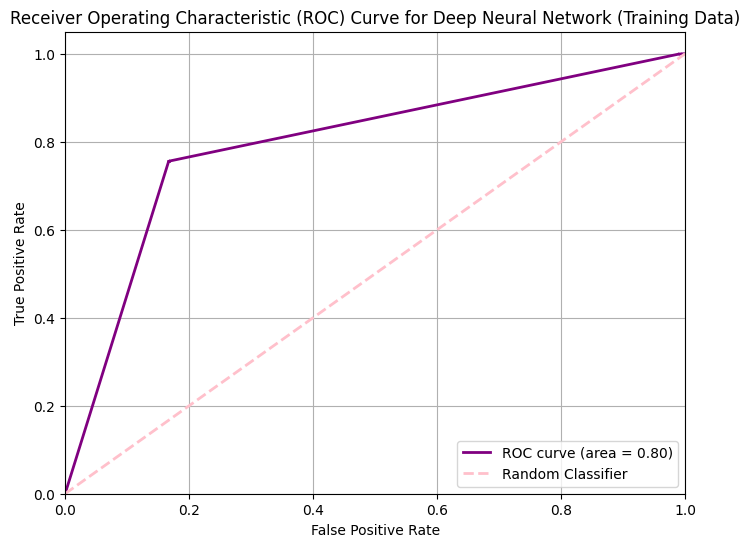

In [24]:
plot_confusion_matrix(model_Sigmoid)
plot_ROC_curve(model_Sigmoid)